# Credit Card Frau Data Set - Outlier Detection
In this project, we take the [Credit Card Fraud Data set](https://www.kaggle.com/mlg-ulb/creditcardfraud) from Kaggle.<br>
Our aim is to train a model that is able to differentiate normal credit card transactions from fraudulent transactions.

In [1]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

In [2]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [3]:
import keras
from keras import models
from keras import layers
from keras import callbacks



print( keras.__version__ )

2.2.4


Using TensorFlow backend.


In [4]:
import pandas as pd

print( pd.__version__ )

0.24.2


In [5]:
fraud_data_df = pd.read_csv( "C:\\Users\\rhopi\\OneDrive\\Desktop\\kaggle data 1\\credit card frau data set\\creditcard.csv" )

fraud_data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
print( fraud_data_df.shape )

(284807, 31)


Ok, we got a little more than 280k data points, and each data point has $31$ dimensions, where the dimension __Class__ tells us, whether the case is fraudulent ($1$) or not ($0$).<br>
Let's find out, how many fraudulent cases there are.

In [7]:
print( fraud_data_df.loc[ fraud_data_df[ "Class" ] == 1 ].shape[ 0 ] )

492


This is good news. Only $492$ cases of fraudulent data. Seems like most people are no criminals.<br>
Our strategy will now be the following: we will select the first $10000$ data points of normal data. We will normalize these data and train an __autoencoder__ on these data. Since the fraudulent data do not look like the normal data, the __encoder__ will map these data far away from the normal data. We then can train a simple model like a random forest to classify the data.<br>
We start with selecting the first $10000$ data points and the preparation of the training and test data sets.<br>
We will ignore the __Time__, since fraud has nothing to do with time.

In [8]:
auto_train = np.zeros( shape = [ 10000, 29 ] )

mu = np.zeros( [ 29 ] )

sigma = np.zeros( [ 29 ] )

dim_min = np.zeros( [ 29 ] )

dim_max = np.zeros( [ 29 ] )

In [9]:
auto_train = fraud_data_df.loc[ fraud_data_df[ "Class" ] == 0  ].iloc[ 0 : 10000 ].drop( [ "Time", "Class" ], axis = 1 ).to_numpy()

In [10]:
for i in range( 29 ):
    
    mu[ i ] = np.mean( auto_train[ :, i] )
    
    sigma[ i ] = np.std( auto_train[ :, i] )
    
    dim_min[ i ] = np.min( ( auto_train[ :, i ] - mu[ i ] ) / sigma[ i ] )
    
    dim_max[ i ] = np.max( ( auto_train[ :, i ] - mu[ i ] ) / sigma[ i ] )

In [11]:
def transformer( data, mu, sigma, dim_min, dim_max ):
    """
        transformer takes an array and normalizes each column using the mean from mu and the standard deviation
        from sigma. Then, the data from dim_min and dim_max are used to clip the data.
    """
    
    for i in range( 29 ):
        
        data[ :, i ] = ( data[ :, i ] - mu[ i ] ) / sigma[ i ]
        
        data[ :, i ] = np.clip( data[ :, i ], a_min = dim_min[ i ], a_max = dim_max[ i ] )
        
    return data

In [12]:
auto_train = transformer( auto_train, mu, sigma, dim_min, dim_max )

Now, that we have built the __transformer__, we prepare the training and the test data for the random forest.

In [13]:
forest_data_ok = fraud_data_df[ fraud_data_df[ "Class" ] == 0 ].iloc[ 10000 : ].drop( [ "Time", "Class" ], axis = 1 ).to_numpy()

forest_data_not_ok = fraud_data_df[ fraud_data_df[ "Class" ] == 1 ].drop( [ "Time", "Class" ], axis = 1 ).to_numpy()

In [14]:
forest_data_ok = transformer( forest_data_ok, mu, sigma, dim_min, dim_max )

forest_data_not_ok = transformer( forest_data_not_ok, mu, sigma, dim_min, dim_max )

Now, we have performed the essential data transformations. We now split the data into training and test data using a $70-30$ split.

In [15]:
print( np.round( 0.7 * np.shape( forest_data_ok )[ 0 ] ), np.shape( forest_data_ok )[ 0 ] - np.round( 0.7 * np.shape( forest_data_ok )[ 0 ] ) )

192020.0 82295.0


In [16]:
print( np.round( 0.7 * np.shape( forest_data_not_ok )[ 0 ] ), np.shape( forest_data_not_ok )[ 0 ] - np.round( 0.7 * np.shape( forest_data_not_ok )[ 0 ] ) )

344.0 148.0


In [17]:
forest_train_ok_x = np.zeros( shape = [ 192020, 29 ] )

forest_train_ok_y = np.zeros( shape = [ 192020 ] )

forest_test_ok_x = np.zeros( shape = [ 82295, 29 ] )

forest_test_ok_y = np.zeros( shape = [ 82295 ] )

forest_train_not_ok_x = np.zeros( shape = [ 344, 29 ] )

forest_train_not_ok_y = np.zeros( shape = [ 344 ] ) + 1.0

forest_test_not_ok_x = np.zeros( shape = [ 148, 29 ] )

forest_test_not_ok_y = np.zeros( shape = [ 148 ] ) + 1.0

In [18]:
indices_ok_train = np.sort( np.random.choice( range( 192020 + 82295 ), size = 192020, replace = False ) )

indices_ok_test = []

i = 0

for j in range( 192020 + 82295 ):
    
    if j == indices_ok_train[ i ]:
        
        i = i + 1
        
    else:
        
        indices_ok_test.append( j )

In [19]:
indices_not_ok_train = np.sort( np.random.choice( range( 344 + 148 ), size = 344, replace = False ) )

indices_not_ok_test = []

i = 0

for j in range( 344 + 148 ):
    
    if j == indices_not_ok_train[ i ]:
        
        i = i + 1
        
    else:
        
        indices_not_ok_test.append( j )

In [20]:
forest_train_ok_x = forest_data_ok[ indices_ok_train, : ]

forest_test_ok_x = forest_data_ok[ indices_ok_test, : ]

forest_train_not_ok_x = forest_data_not_ok[ indices_not_ok_train, : ]

forest_test_not_ok_x = forest_data_not_ok[ indices_not_ok_test, : ]

In [21]:
forest_train_x = np.concatenate( ( forest_train_ok_x, forest_train_not_ok_x ) )

forest_train_y = np.concatenate( ( forest_train_ok_y, forest_train_not_ok_y ) )

forest_test_x = np.concatenate( ( forest_test_ok_x, forest_test_not_ok_x ) )

forest_test_y = np.concatenate( ( forest_test_ok_y, forest_test_not_ok_y ) )

Now, that we have prepared all the data, we code the __autoencoder__.

In [22]:
input_encoder = keras.engine.input_layer.Input( shape = ( 29, ) )

encoder_layer1 = layers.Dense( 256, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_encoder )

encoder_layer2 = layers.Dense( 128, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer1 )

encoder = keras.Model( input_encoder, encoder_layer2 )

encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               7680      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
Total params: 40,576
Trainable params: 40,576
Non-trainable params: 0
_________________________________________________________________


C:\Users\rhopi\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [23]:
input_decoder = keras.engine.input_layer.Input( shape = ( 128, ) )

decoder_layer1 = layers.Dense( 256, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_decoder )

decoder_layer2 = layers.Dense( 29, activation = layers.LeakyReLU( alpha = 0.3 ) )( decoder_layer1 )

decoder = keras.Model( input_decoder, decoder_layer2 )

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 29)                7453      
Total params: 40,477
Trainable params: 40,477
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder = keras.Model( input_encoder, decoder( encoder( input_encoder ) ) )

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
model_1 (Model)              (None, 128)               40576     
_________________________________________________________________
model_2 (Model)              (None, 29)                40477     
Total params: 81,053
Trainable params: 81,053
Non-trainable params: 0
_________________________________________________________________


In [25]:
autoencoder.compile( optimizer = keras.optimizers.SGD( lr = 0.1, momentum = 0.0, decay = 0.0, nesterov = False ),
               loss = "mean_squared_error", metrics = None )

autoencoder.fit( auto_train, auto_train, batch_size = 100, epochs = 100, shuffle = True )

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
10000/10000 [==============================] - 2s 176us/step - loss: 0.8079
Epoch 2/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.4678
Epoch 3/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.2802
Epoch 4/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.1853
Epoch 5/100
10000/10000 [==============================] - 0s 22us/step - loss: 0.1394
Epoch 6/100
10000/10000 [==============================] - 0s 22us/step - loss: 0.1124
Epoch 7/100
10000/10000 [==============================] - 0s 22us/step - loss: 0.0960
Epoch 8/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0867
Epoch 9/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0791
Epoch 10/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0745
Epoch 11/100
10000/10000 [==============================] - 0s 24us/step - loss:

10000/10000 [==============================] - 0s 23us/step - loss: 0.0161
Epoch 92/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0164
Epoch 93/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0160
Epoch 94/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0164
Epoch 95/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0157
Epoch 96/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0156
Epoch 97/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0156
Epoch 98/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0153
Epoch 99/100
10000/10000 [==============================] - 0s 23us/step - loss: 0.0163
Epoch 100/100
10000/10000 [==============================] - 0s 22us/step - loss: 0.0152


Now, we have trained the __autoencoder__ on non fraudulent data. We now can map the $29$-dimensional data into a $128$-dimensional space. Sincce the __autoencoder__ only saw non-fraudulent data, we expect, that fraudulent data are mapped far away from the non-fraudulent data.

In [26]:
mapped_train_x = encoder.predict( forest_train_x )

mapped_test_x = encoder.predict( forest_test_x )

Let's have a look at the mapped data. We use __t-sne__ for the dimensionality reduction. Since __t-sne__ is quite expensive, we look only at the last $2000$ data points from __mapped_train_x__.

In [27]:
import sklearn
from sklearn.manifold import TSNE

print( sklearn.__version__ )

0.20.3


In [28]:
two_d = TSNE( n_components = 2 ).fit_transform( X = mapped_train_x[ ( 190020 + 344 ) : ( 192020 + 344 ), :  ] ) 

In [29]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [30]:
colors = []

for i in range( ( 190020 + 344 ), ( 192020 + 344 ) ):
    
    if forest_train_y[ i ] == 1:
        
        colors.append( "blue" )
        
    else:
        
        colors.append( "red" )

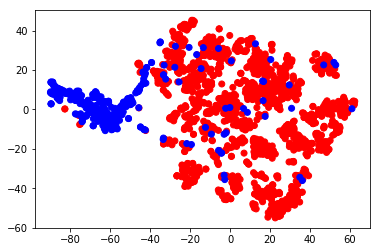

In [31]:
plt.scatter( two_d[ :, 0 ], two_d[ :, 1 ], c = colors )

Now, what is this? We trained the __autoencoder__ on $10000$ non-fraudulent data points. Then we mapped data containing fraudulent and non-fraudulent data into a $128$-dimensional space using the __encoder__ from the __autoencoder__. These $128$-dimensional data were then mapped back to a $2$-dimensional space using __t-sne__. Then we colored the fraudulent data in blue, and the non-fraudulent data in red. Even though the __encoder__ never saw fraudulent data, it learned, what non-fraudulent data look like, and therefore, it mapped fraudulent data away from non-fraudulent data.<br>
Now let's train a random forest on the mapped data.

In [32]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [33]:
forest = RFC()

In [34]:
forest.fit( mapped_train_x, forest_train_y )

C:\Users\rhopi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
prediction = forest.predict( mapped_test_x )

In [36]:
from sklearn.metrics import classification_report

In [37]:
print( classification_report( forest_test_y, prediction ) )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     82295
         1.0       0.97      0.76      0.85       148

   micro avg       1.00      1.00      1.00     82443
   macro avg       0.98      0.88      0.92     82443
weighted avg       1.00      1.00      1.00     82443



This report tells us the following:<br>
For the non-fraudulent data, the random forest classifier works really good.<br>
For the fraudulent data, there are some minor problems: some non-fraudulent data were wrongly classified as fraudulent, and therefore, the precision, which is the ratio between true fraudulent cases and predicted fraudulent cases is less than $1$. However: since the precision is almost $1$, only a few non-fraudulent cases were wrongfully classified as fraudulent. The recall measures, how many true positive cases where classified and sets this in relation to the number of positive cases. Here, a value of $0.76$ means, that a quarter of the fraudulent cases where wrongfully classified as non-fraudulent. 